# Modeling

The following notebook continues the work of a thesis centered around the quantitative exploration of the literary genre Gothic Fiction with the help of a number of tools established within the distant reading community. A community of literary scholars and digital humanists set on approaching, analyzing and interpreting texts from afar with computational means.

This section deals with the creation and optimization of topic models, as well as the enrichment of the topic distribution by document with the features taken from the preprocessing section. For the creation of these models the Python library OCTIS: Optimizing and Comparing Topic Models is Simple! is used, the model is optimized with Scikit-Optimize, enriched with NLTK sentiment scores on the texts.

In [ ]:
from octis.evaluation_metrics.diversity_metrics import WordEmbeddingsInvertedRBOCentroid, TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence, WECoherenceCentroid
from octis.models.model import load_model_output, save_model_output
from octis.preprocessing.preprocessing import Preprocessing
from octis.optimization.optimizer import Optimizer
from octis.optimization.optimizer_tool import plot_bayesian_optimization, convergence_res
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from skopt.space import Integer, Real, Categorical
from octis.dataset.dataset import Dataset
from gensim.models import Word2Vec
from IPython.display import Image
from octis.models.LDA import LDA
from octis.models.CTM import CTM
from octis.models.LSI import LSI
from octis.models.ETM import ETM
from gensim.models import Word2Vec
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter
from joblib import load, dump
import pandas as pd
import numpy as np
import gensim
import string
import spacy
import nltk
import time
import os
import re

Three different variants of OCTIS models will be optimized and trained: 
1) The standard latent dirichlet allocation (LDA) in its Gensim implementation. 
2) A contextualized topic model (CTM) relying heavily on the use of contextualized transformer models like Bert.
3) (ETM) - "Topic Modeling in Embedding Spaces", a topic model which draws its topics and words from the embedding space of the original corpus using word2vec.

Note: The structure is identical for all three models and in the subsequent section only the LDA will be used for analysis. The CTM and ETM mainly serve as a source of comparison for the topic distribution throughout time to test for its consistency.

In [ ]:
word2vec_model = Word2Vec.load("./word2vec/word2vec_model")
df_ref=pd.read_csv('./preprocessing/results/df_books_prep.csv')
df_input=pd.read_csv('./preprocessing/results/df_books_chunk.csv')

In [20]:
df_input['tokenized_text'] = df_input['preprocessed_text'].apply(lambda text: text.split())

To improve the salience of the results Mimno et all have argued for the importance of filtering a corpus to remove the most frequent, as well as the rarest terms to make for more meaningful results.
As thresholds, they have proposed removing the top 5 to 10 percent of the most frequent terms, as well as removing everything that doesn't appear at least 5-10 times in the whole corpus.

In [21]:
# Create a frequency distribution
word_freq = Counter(word for doc in df_input['tokenized_text'] for word in doc)

# Identify words to filter
total_words = len(word_freq)
top_5_percent = int(total_words * 0.05)
most_common_words = set(word for word, freq in word_freq.most_common(top_5_percent))
least_frequent_words = set(word for word, freq in word_freq.items() if freq < 5)

# Combine the sets of words to remove
words_to_remove = most_common_words.union(least_frequent_words)

# Filter words from each document
df_input['filtered_tokens'] = df_input['tokenized_text'] .apply(lambda doc: [word for word in doc if word not in words_to_remove])

# Optionally, rejoin tokens into a single string
df_input['filtered_text'] = df_input['filtered_tokens'].apply(' '.join)

Transforming the corpus in the necessary input format required for the OCTIS imput data pipeline

In [22]:
# Writing 'filtered_text' column to 'corpus.txt'
with open('./octis/corpus.txt', 'w', encoding='utf-8') as corpus_file:
    for preprocessed_text in df_input['filtered_text']:
        corpus_file.write(preprocessed_text + '\n')

# creating an input vocabulary file

vocabulary = set()

for text in df_input['filtered_text']:
    vocabulary.update(text.split())

with open('./octis/vocabulary.txt', 'w') as vocab_file:
    for word in sorted(vocabulary):
        vocab_file.write(word + '\n')

In [24]:
# octis expects a binary, not a model object
word2vec_model.wv.save_word2vec_format('./word2vec/word2vec_model.bin', binary=True)

The variant of the dataset for model training and the variant for final analysis and interpretation differ only by the former carrying a split into a training, test and validation set.

In [3]:
preprocessor = Preprocessing(vocabulary=None, save_original_indexes=True, max_features=None,
                             remove_punctuation=True, punctuation=string.punctuation, 
                             lemmatize=False, stopword_list='english',
                             min_chars=1, min_words_docs=0)
# preprocess
dataset = Dataset()
dataset = preprocessor.preprocess_dataset(documents_path=r'/Storage/Studium/DigitalHumanities/Semester5/Thesis/code_notebooks/octis/corpus.txt')

dump(dataset, './octis/dataset.joblib')
dataset=load('./octis/dataset.joblib')

In [5]:
preprocessor = Preprocessing(vocabulary=None, save_original_indexes=True, max_features=None,
                             remove_punctuation=True, punctuation=string.punctuation, 
                             lemmatize=False, stopword_list='english',split=False, 
                             min_chars=1, min_words_docs=0)
# preprocess
dataset_final = Dataset()
dataset_final = preprocessor.preprocess_dataset(documents_path=r'/Storage/Studium/DigitalHumanities/Semester5/Thesis/code_notebooks/octis/corpus.txt')

dump(dataset_final, './octis/dataset_final.joblib')
dataset_final=load('./octis/dataset_final.joblib')

# Model Training

#### LDA

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics.

OCTIS - intrinsic optimization pipeline is skopt. All three models are optimized based on Word Embedding Coherence Centroid, a normalized metric which draws from an embedding space drawn from the original corpus to allow for a more domain-specific evaluation and closer fit to the texts in use. In addition, as a secondary metric, Diversity Centroid was chosen to influence the choice of model parameters towards a broader coverage of content inherent in the texts. The optimization method chosen by OCTIS by default is Bayesian, which is a resource-intensive stochastic approach well suited for otherwise difficult-to-optimize or evaluate models, which are treated as a black-box input.

In [ ]:

# Define the hyperparameter space
parameter_space = {
    'num_topics': Integer(50, 101),  # Range of topics as integer
    'alpha': Real(0.001, 10, prior='uniform'),  # Dirichlet hyperparameter for document-topic distribution
    'eta': Real(0.001, 10, prior='uniform')  # Dirichlet hyperparameter for topic-word distribution
}

# Define the model
lda_model = LDA(num_topics=60, alpha=0.09, eta=5.0)

optimization_runs=200
model_runs=3

coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)  
#topic_diversity = TopicDiversity(topk=10)
DiversityCentroid=WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
# Run the hyperparameter optimization
start = time.time()

optimizer=Optimizer()
optimizer_results_LDA = optimizer.optimize(model=lda_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=optimization_runs, 
                        n_random_starts=5,surrogate_model='RF',
                        model_runs=model_runs, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid],save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_LDA.save_to_csv("./octis/results/Opt_LDAresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')


In [28]:
dump(optimizer_results_LDA, './octis/models/optimizer_results_LDA_long.joblib', compress=('lzma', 9))

['./octis/models/optimizer_results_LDA_long.joblib']

In [3]:
optimizer_results_LDA=load('./octis/models/optimizer_results_LDA_long.joblib')

In [29]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the opposite, so the result is inverted here.

values_to_plot_LDA = [-x for x in optimizer_results_LDA.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_LDA, 
                          name_plot="LDA_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

The optimization was successful

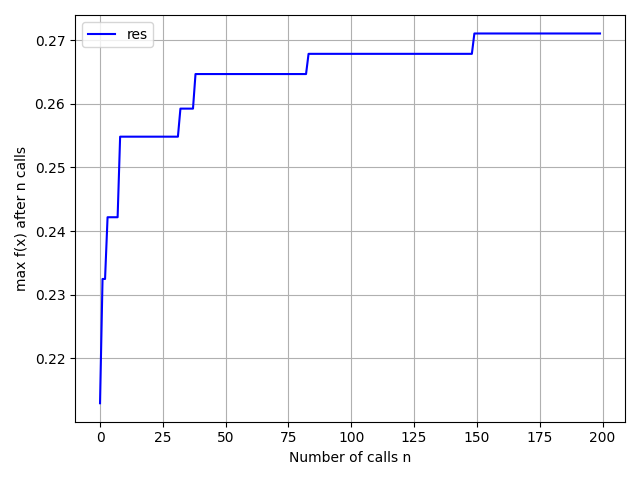

In [8]:
#The image is just dumped into the working directory, but moved somewhere more fitting
os.replace('./LDA_Optimization_Convergence.png', './octis/results/LDA_Optimization_Convergence.png')

Image(filename='./octis/results/LDA_Optimization_Convergence.png')

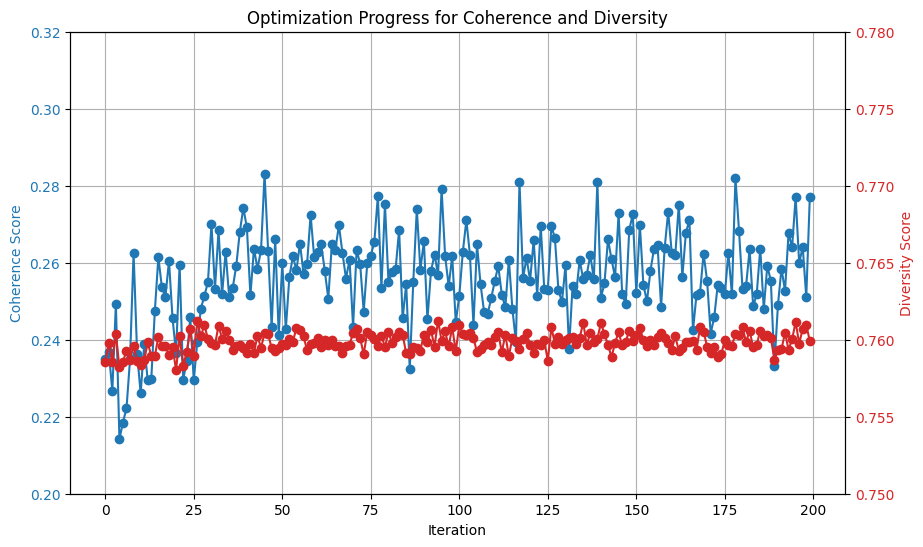

In [31]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid', our two metrics
coherence_scores_LDA = [max(run) for run in optimizer_results_LDA.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_LDA = [max(run) for run in optimizer_results_LDA.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Creating a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_LDA, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0.20, 0.32)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_LDA, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

For the choice of the best hyperparameters, the coherence values are primarily taken into account, but diversity is used as a secondary criterion. Of the ten best coherence scores the parameter set with the highest diversity score is selected.

In [32]:
# Extract the best configurations based on coherence scores
coherence_scores_LDA = optimizer_results_LDA.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_LDA = optimizer_results_LDA.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extract scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_LDA.values(), diversity_scores_LDA.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    alpha = optimizer_results_LDA.info['x_iters']['alpha'][i]
    eta = optimizer_results_LDA.info['x_iters']['eta'][i]
    num_topics = optimizer_results_LDA.info['x_iters']['num_topics'][i]
    combined_scores.append((max_coherence, max_diversity, alpha, eta, num_topics))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_LDA = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_LDA[0])
print("Corresponding Diversity Score:", best_overall_LDA[1])
print("Best Configuration: num_topics =", best_overall_LDA[4], ", alpha =", best_overall_LDA[2], ", eta =", best_overall_LDA[3])

Best Coherence Score: 0.27711903966818585
Corresponding Diversity Score: 0.7611531671767668
Best Configuration: num_topics = 73 , alpha = 0.06460320991688963 , eta = 2.9415645388839033


In [33]:
best_num_topics = best_overall_LDA[4]
best_alpha = best_overall_LDA[2]
best_eta = best_overall_LDA[3]

# Now instantiate the LDA model with the best hyperparameters
best_model_LDA = LDA(num_topics=best_num_topics, 
                 alpha=best_alpha, 
                 eta=best_eta)

# Disable partitioning to use the entire dataset
best_model_LDA.partitioning(use_partitions=False)

best_model_LDA = best_model_LDA.train_model(dataset_final)

In [3]:
dump(best_model_LDA,'./octis/models/best_model_LDA.joblib', compress=('lzma', 9))
best_model_LDA = load('./octis/models/best_model_LDA.joblib')

The topic output for the optimal model

In [35]:
top_words_per_topic_LDA = best_model_LDA['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_LDA):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['relation', 'sex', 'pressure', 'driver', 'delicacy', 'arranged', 'ruins', 'curtains', 'impatient', 'willing']
Topic 2 : ['plague', 'louder', 'motives', 'foreign', 'travel', 'examined', 'disappointment', 'prince', 'authority', 'prisoner']
Topic 3 : ['toll', 'winds', 'roar', 'tide', 'stage', 'lovers', 'er', 'sits', 'represented', 'wheels']
Topic 4 : ['milk', 'outline', 'fountain', 'staff', 'sunset', 'yonder', 'obtained', 'splendid', 'entire', 'fruit']
Topic 5 : ['abbot', 'assist', 'virtues', 'revenge', 'sons', 'labour', 'agitation', 'harm', 'delivered', 'amiable']
Topic 6 : ['abode', 'examined', 'obtained', 'gallery', 'disappointment', 'travel', 'ice', 'mile', 'arranged', 'that']
Topic 7 : ['beast', 'purple', 'lid', 'rare', 'camp', 'monster', 'the', 'marvellous', 'fashionable', 'merry']
Topic 8 : ['prophet', 'inspired', 'cavern', 'kings', 'ridiculous', 'yonder', 'crimson', 'wave', 'glare', 'lamps']
Topic 9 : ['the', 'quality', 'park', 'prince', 'guilt', 'disappointment', 'magn

In [36]:
dump(top_words_per_topic_LDA,'./analysis/top_words_per_topic_LDA.joblib')

['./analysis/top_words_per_topic_LDA.joblib']

#### Preparing the results for further analysis

We extract the topic distribution from the model and combine it with the metadata and features from the original dataframe.

In [11]:
def get_document_topic_percentages(topic_document_matrix):
    
    num_docs = topic_document_matrix.shape[1]
    num_topics = topic_document_matrix.shape[0]
    data = []
    
    # Iterate over each document
    for doc_index in range(topic_document_matrix.shape[1]):
        # Get topic distribution for the document
        topic_distribution = topic_document_matrix[:, doc_index]
        
        data.append([round(percentage * 100, 2) for percentage in topic_distribution])

    column_names = [f"Topic {i+1}" for i in range(num_topics)]
    df = pd.DataFrame(data, columns=column_names)
    df.index.name = "Document ID"
    return df

In [12]:
topic_document_matrix_LDA = best_model_LDA["topic-document-matrix"]
topic_distribution_df_LDA = get_document_topic_percentages(topic_document_matrix_LDA)
topic_distribution_df_LDA.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73
Document ID,,,,,,,,,,,,,,,,,,,,,
0,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,36.64,0.03,0.03,0.03
1,0.19,2.68,0.36,1.12,2.18,1.21,0.34,1.00,0.50,0.67,...,0.31,1.17,0.00,0.00,0.35,0.89,2.27,0.24,0.00,0.85
2,0.25,0.49,0.91,1.05,7.00,1.43,0.54,1.57,1.35,2.61,...,0.65,2.13,0.54,0.43,0.18,2.91,12.59,0.84,0.00,0.90
3,0.00,0.43,0.00,0.18,8.61,0.83,0.00,1.36,0.01,0.43,...,0.23,0.37,0.00,0.00,0.00,0.23,0.22,0.11,0.00,0.00
4,0.21,0.01,0.01,2.16,11.04,4.61,3.06,0.33,3.96,1.46,...,0.82,6.64,0.56,0.01,1.11,3.25,3.79,0.50,0.01,0.80
5,0.39,0.01,0.39,0.26,2.53,8.84,1.24,0.89,1.15,2.87,...,0.11,8.06,0.59,0.13,0.00,0.25,1.97,1.10,0.08,0.00
6,0.00,0.71,0.87,0.68,10.97,4.35,0.34,0.82,3.14,1.12,...,0.15,8.92,1.84,0.17,0.85,4.13,2.10,0.29,0.00,1.26
7,0.01,0.01,1.24,1.06,2.34,0.07,0.45,1.49,0.01,5.21,...,0.01,1.88,2.63,0.01,0.01,1.35,11.11,0.12,0.40,0.01
8,0.07,0.45,1.86,2.02,16.63,2.75,1.95,0.93,1.02,0.58,...,1.07,2.36,1.64,0.02,0.17,1.51,3.10,1.34,0.00,2.48


In [13]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_LDA['Original Document Index'] = original_indexes

The rows of the original document are sampled in random order when passed into octis as a dataset in case the default split=True parameter is set. A necessity to allow for hold-out data in the parameter optimization. Thus the document order is scrambled. For the sake of retraining a model with optimal parameters on the full corpus, when the parameter is set to False, the order of documents is maintained and can be easily rejoined. For safety's sake, we will join according to the order of the indices nonetheless.

In order to further enrich the data, we will add the sentiment to the dataframe using the defacto standard for sentiment analysis VADER.

In [14]:
nltk.download('vader_lexicon')

def add_sentiment_scores(df, text_column):

    sia = SentimentIntensityAnalyzer()

    # Calculate sentiment scores
    df['sentiment'] = df[text_column].apply(lambda text: sia.polarity_scores(text)['compound'])

    return df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/florian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
add_sentiment_scores(df_input, 'preprocessed_text')

,preprocessed_text,reference,sentiment
0,fragment adventure turned steed hoping cross d...,Aikin_SirBertran_1,-0.9201
1,plague portion ensuing relating street manner ...,Ainsworth_OldSaintPa_1,0.9773
2,whatsoever away terms included language charac...,Ainsworth_Rookwood_1,0.9989
3,doll wangos leaving justice skill witches spea...,Ainsworth_TheLancash_1,-0.9998
4,note text little work finished year intended i...,Austen_Northanger_1,1.0000
...,...,...,...
217,friend worth letters intimacies acquaintances ...,LeFanu_InaGlassDa_5,1.0000
218,happened carriage crowd leaving ball begged go...,LeFanu_InaGlassDa_6,0.9998
219,distinct reached ears henceforward distinctly ...,LeFanu_InaGlassDa_7,0.9999
220,laugh came wonder wise man hippogriffs dragons...,LeFanu_InaGlassDa_8,1.0000


In [16]:
df_input['input_index'] = df_input.index
df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
df_merge['date'] = df_merge['date'].astype('Int64')
df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
df_merge.head()

,preprocessed_text_x,reference_x,sentiment,input_index,ref,index,reference_y,title,author,date,...,mode,genre,gender,birthdate,nationality,role (central/peripheral/influence),text,source,preprocessed_text_y,tokenized_text
0,fragment adventure turned steed hoping cross d...,Aikin_SirBertran_1,-0.9201,0,Aikin_SirBertran,0,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,...,Fragment,Gothic,NaN,<NA>,English,Central,"SIR BERTRAND, A FRAGMENT:\n\nAFTER this advent...",colors,fragment adventure turned steed hoping cross d...,"['fragment', 'adventure', 'turned', 'steed', '..."
1,plague portion ensuing relating street manner ...,Ainsworth_OldSaintPa_1,0.9773,1,Ainsworth_OldSaintPa,1,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,...,NaN,NaN,m,1805,English,NaN,OLD SAINT PAUL\'S\n\n _A TALE OF THE PLAGUE\n...,pb-manual,plague portion ensuing relating street manner ...,"['plague', 'portion', 'ensuing', 'relating', '..."
2,whatsoever away terms included language charac...,Ainsworth_Rookwood_1,0.9989,2,Ainsworth_Rookwood,2,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,...,Novel,Gothic,m,1805,English,Central,"\nThe Project Gutenberg EBook of Rookwood, by ...",colors,whatsoever away terms included language charac...,"['whatsoever', 'away', 'terms', 'included', 'l..."
3,doll wangos leaving justice skill witches spea...,Ainsworth_TheLancash_1,-0.9998,3,Ainsworth_TheLancash,3,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,...,NaN,NaN,m,1805,English,NaN,Proofreading Team.\n\n\n\n\n\n\n[Illustration:...,pb-manual,doll wangos leaving justice skill witches spea...,"['doll', 'wangos', 'leaving', 'justice', 'skil..."
4,note text little work finished year intended i...,Austen_Northanger_1,1.0000,4,Austen_Northanger,5,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,...,NaN,NaN,f,1775,English,NaN,Northanger Abbey\n\n\nby Jane Austen\n\n(1803)...,gutenberg,note text little work finished year intended i...,"['note', 'text', 'little', 'work', 'finished',..."


In [17]:
# merging of topic distribution with features
# reorganizing the order of columns and cleanup
df_txt_features_LDA = df_merge.merge(topic_distribution_df_LDA, right_on='Original Document Index', left_on='input_index')
df_txt_features_LDA=df_txt_features_LDA.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
df_txt_features_LDA.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
df_txt_features_LDA = df_txt_features_LDA[['input_index'] + [col for col in df_txt_features_LDA.columns if col != 'input_index']]
df_txt_features_LDA.rename(columns={'role (central/peripheral/influence)': 'role'}, inplace=True)
df_txt_features_LDA.head()

,input_index,reference,sentiment,text_key,title,author,date,period,mode,genre,...,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73
0,0,Aikin_SirBertran_1,-0.9201,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,Romantic,Fragment,Gothic,...,0.03,0.03,0.03,0.03,0.03,0.03,36.64,0.03,0.03,0.03
1,1,Ainsworth_OldSaintPa_1,0.9773,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,NaN,NaN,NaN,...,0.31,1.17,0.00,0.00,0.35,0.89,2.27,0.24,0.00,0.85
2,2,Ainsworth_Rookwood_1,0.9989,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,NaN,Novel,Gothic,...,0.65,2.13,0.54,0.43,0.18,2.91,12.59,0.84,0.00,0.90
3,3,Ainsworth_TheLancash_1,-0.9998,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,NaN,NaN,NaN,...,0.23,0.37,0.00,0.00,0.00,0.23,0.22,0.11,0.00,0.00
4,4,Austen_Northanger_1,1.0000,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,NaN,NaN,NaN,...,0.82,6.64,0.56,0.01,1.11,3.25,3.79,0.50,0.01,0.80


In [18]:
df_txt_features_LDA.to_csv('./analysis/df_txt_features_LDA.csv', index=False)

creating exportable model metrics to use them in pyLDAdavis in the next notebook

In [19]:
topic_term_dists_LDA= best_model_LDA["topic-word-matrix"]
doc_topic_dists_LDA = best_model_LDA["topic-document-matrix"]
doc_topic_dists_LDA = doc_topic_dists_LDA.T
vocab = dataset_final.get_vocabulary()
doc_lengths = [len(doc) for doc in dataset_final.get_corpus()]

In [20]:
corpus = dataset_final.get_corpus()

# Initialize term frequency dictionary
term_frequency_dict = {term: 0 for term in vocab}

# Count the frequency of each term in the corpus
for document in corpus:
    for word in document:
        if word in term_frequency_dict:
            term_frequency_dict[word] += 1

# Convert term frequencies to a list in the order of the vocabulary
term_frequency= [term_frequency_dict[word] for word in vocab]

Export for the analysis

In [21]:
dump(topic_term_dists_LDA, './analysis/topic_term_dists_LDA.joblib')
dump(doc_topic_dists_LDA, './analysis/doc_topic_dists_LDA.joblib')
dump(vocab, './analysis/vocab.joblib')
dump(doc_lengths, './analysis/doc_lengths.joblib')
dump(term_frequency, './analysis/term_frequency.joblib')

['./analysis/term_frequency.joblib']

#### The following two sections replicate the same set up for the other two models, in order to provide a source of comparison on the topic distribution throughout time

#### CTM

A contextualized topic model (CTM) relying heavily on the use of contextualized transformer models, again evaluated on the basis of Word Embedding Coherence Centroid and Diversity Centroid.

In [ ]:
# Initialize the CTM model with some default parameters
ctm_model = CTM(batch_size=128, num_epochs=30, inference_type='zeroshot', bert_model="bert-base-nli-mean-tokens")

# Define the hyperparameter space for CTM
parameter_space = {
    'num_topics': Integer(50, 100),
    'num_layers': Categorical([1, 2, 3]),
    'num_neurons': Categorical([100, 200, 300, 500, 750, 1000]),
    'learn_rate':Real(0.001, 0.1), 
    'optimizer': Categorical(['adam', 'sgd', 'msprop']),
    'dropout': Real(0.0, 0.9, prior='uniform')
}

# Define the evaluation metric
coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
DiversityCentroid = WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)

# Run the hyperparameter optimization
start = time.time()

optimizer = Optimizer()
optimizer_results_CTM = optimizer.optimize(model=ctm_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=200, 
                        n_random_starts=5, surrogate_model='RF',
                        model_runs=3, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid], save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_CTM.save_to_csv("./octis/results/Opt_CTMresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

In [50]:
dump(optimizer_results_CTM, './octis/models/optimizer_results_CTM.joblib', compress=('lzma', 9))

['./octis/models/optimizer_results_CTM.joblib']

In [45]:
optimizer_results_CTM = load('./octis/models/optimizer_results_CTM.joblib')

In [51]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the opposite, so the result is inverted

values_to_plot_CTM = [-x for x in optimizer_results_CTM.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_CTM, 
                          name_plot="CTM_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

This optimization was less smooth and clear, but reruns could not provide any improvement

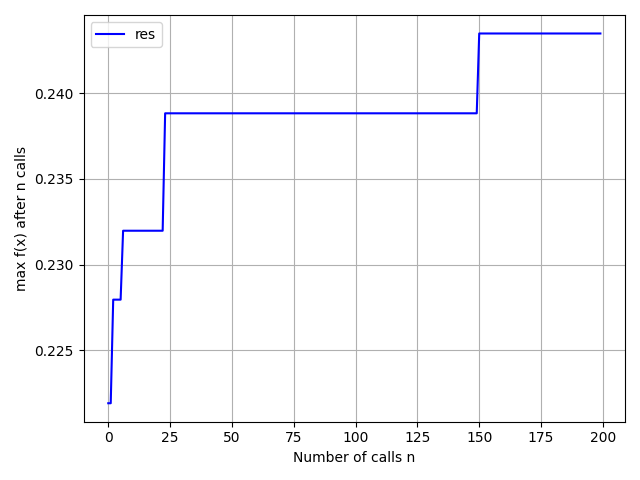

In [52]:
#The image is just dumped into the working directory, but is moved somewhere more fitting
os.replace('./CTM_Optimization_Convergence.png', './octis/results/CTM_Optimization_Convergence.png')

Image(filename='./octis/results/CTM_Optimization_Convergence.png')

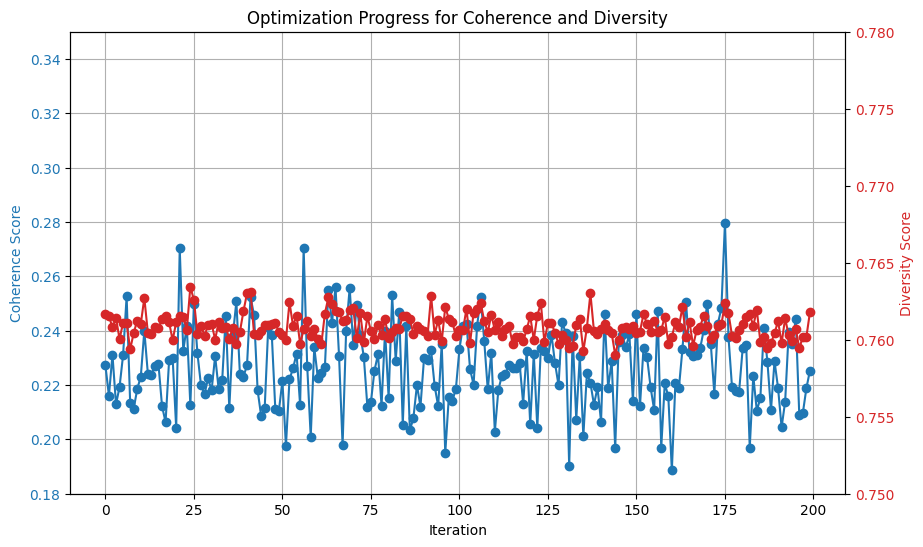

In [46]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid' the two metrics
coherence_scores_CTM = [max(run) for run in optimizer_results_CTM.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_CTM = [max(run) for run in optimizer_results_CTM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Create a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_CTM, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0.18, 0.35)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_CTM, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

In [48]:
# Extract the best configurations based on coherence scores
coherence_scores_CTM = optimizer_results_CTM.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_CTM = optimizer_results_CTM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extracting scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_CTM.values(), diversity_scores_CTM.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    num_topics = optimizer_results_CTM.info['x_iters']['num_topics'][i]
    num_layers = optimizer_results_CTM.info['x_iters']['num_layers'][i]
    num_neurons = optimizer_results_CTM.info['x_iters']['num_neurons'][i]
    learn_rate = optimizer_results_CTM.info['x_iters']['learn_rate'][i]
    optimizer_param = optimizer_results_CTM.info['x_iters']['optimizer'][i]
    dropout = optimizer_results_CTM.info['x_iters']['dropout'][i]
   
    combined_scores.append((max_coherence, max_diversity, num_topics, num_layers, num_neurons, learn_rate, optimizer_param, dropout))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_CTM = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_CTM[0])
print("Corresponding Diversity Score:", best_overall_CTM[1])
print("Best Configuration: num_topics =", best_overall_CTM[2], ", num_layers =", best_overall_CTM[3], ", num_neurons =", best_overall_CTM[4], 
      ", learn_rate =", best_overall_CTM[5], ", optimizer =", best_overall_CTM[6], ", dropout =", best_overall_CTM[7])


Best Coherence Score: 0.25242652543794375
Corresponding Diversity Score: 0.7631295026862059
Best Configuration: num_topics = 52 , num_layers = 1 , num_neurons = 1000 , learn_rate = 0.026875343602901114 , optimizer = sgd , dropout = 0.336284177347719


In [50]:
best_num_topics = best_overall_CTM[2]
best_num_layers = best_overall_CTM[3]
best_num_neurons = best_overall_CTM[4]
best_learn_rate = best_overall_CTM[5]
best_optimizer = best_overall_CTM[6]
best_dropout = best_overall_CTM[7]

# Now we instantiate the CTM model with the best hyperparameters
best_model_CTM = CTM(num_topics=best_num_topics,
                     num_layers=best_num_layers,
                     num_neurons=best_num_neurons,
                     solver=best_optimizer,
                     dropout=best_dropout, 
                     batch_size=128,
                     use_partitions=False,
                     bert_path='./octis/models/'
                     #bert_path='.'
                     )

# Train the model with the dataset
best_model_CTM = best_model_CTM.train_model(dataset_final)

In [51]:
dump(best_model_CTM, './octis/models/best_model_CTM.joblib', compress=('lzma', 9))
best_model_CTM = load('./octis/models/best_model_CTM.joblib')

In [52]:
top_words_per_topic_CTM = best_model_CTM['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_CTM):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['driver', 'prophet', 'fruit', 'pit', 'royal', 'hither', 'queen', 'revenge', 'interview', 'consequences']
Topic 2 : ['driver', 'barn', 'marquis', 'marchioness', 'landlady', 'burrow', 'camels', 'vicar', 'farmer', 'crows']
Topic 3 : ['er', 'major', 'thro', 'evils', 'base', 'feeble', 'splendid', 'horrors', 'goodness', 'victims']
Topic 4 : ['curate', 'card', 'murdered', 'ceiling', 'punch', 'cornet', 'harbor', 'mill', 'treasure', 'cock']
Topic 5 : ['beds', 'crypt', 'lid', 'candles', 'lodged', 'honours', 'hath', 'daddy', 'trenchers', 'untied']
Topic 6 : ['lovers', 'build', 'dismal', 'site', 'earthly', 'suites', 'portal', 'brows', 'millions', 'slab']
Topic 7 : ['honourable', 'valid', 'reserving', 'vicar', 'arbours', 'partisan', 'sum', 'fashionable', 'crape', 'terrace']
Topic 8 : ['valid', 'mill', 'wagon', 'showman', 'vicar', 'hay', 'pinched', 'cabinets', 'barn', 'honourable']
Topic 9 : ['swiftly', 'churchyard', 'onward', 'ing', 'dressing', 'nobleman', 'con', 'woke', 'deliberately', 

In [53]:
dump(top_words_per_topic_CTM,'./analysis/top_words_per_topic_CTM.joblib')

['./analysis/top_words_per_topic_CTM.joblib']

We extract the topic distribution from the model and combine it with the metadata and features from the original dataframe.

In [54]:
topic_document_matrix_CTM = best_model_CTM["topic-document-matrix"]
topic_distribution_df_CTM = get_document_topic_percentages(topic_document_matrix_CTM)
topic_distribution_df_CTM.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50,Topic 51,Topic 52
Document ID,,,,,,,,,,,,,,,,,,,,,
0,0.78,1.18,2.27,1.59,0.70,1.37,1.25,4.50,1.59,2.67,...,0.91,0.98,1.23,1.98,1.69,1.30,3.03,1.07,1.60,6.30
1,2.97,1.33,1.90,3.48,1.10,1.64,1.85,1.76,2.84,8.41,...,3.51,1.10,0.51,2.30,1.73,1.40,0.78,3.97,0.98,2.00
2,2.11,2.37,1.06,3.34,2.25,2.11,2.52,2.24,0.66,2.45,...,6.01,1.54,1.61,3.70,1.07,2.12,1.32,2.10,1.49,0.65
3,0.58,0.92,1.63,0.73,0.29,0.67,0.41,1.69,0.83,0.74,...,0.30,0.45,1.51,1.10,2.33,0.88,0.54,4.56,0.52,25.20
4,0.88,1.27,1.37,1.83,2.86,1.16,1.34,1.29,1.35,1.67,...,4.09,1.60,0.87,1.67,1.99,2.46,1.02,1.32,1.94,1.39
5,1.27,0.82,1.26,1.07,3.70,2.22,1.25,1.02,4.40,1.79,...,5.15,1.42,0.78,1.79,0.89,0.59,1.14,1.85,1.42,0.31
6,4.73,1.62,0.86,2.07,1.09,1.16,2.49,1.82,0.56,1.84,...,1.02,0.79,1.59,2.73,1.97,3.17,1.93,0.46,1.35,2.75
7,3.19,2.26,1.36,2.19,4.39,1.96,1.61,3.26,1.40,2.34,...,3.38,1.50,1.29,1.79,1.93,1.70,1.02,0.69,1.67,0.52
8,7.44,2.23,1.62,1.23,3.45,1.84,1.78,1.19,1.02,2.62,...,1.44,1.26,0.94,2.21,1.05,2.93,1.32,1.01,1.83,1.17


In [55]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_CTM['Original Document Index'] = original_indexes

recasting and minor dataframe adaptations

In [56]:
df_input['input_index'] = df_input.index
df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
df_merge['date'] = df_merge['date'].astype('Int64')
df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
df_merge.head()

,preprocessed_text_x,reference_x,sentiment,input_index,ref,index,reference_y,title,author,date,...,mode,genre,gender,birthdate,nationality,role (central/peripheral/influence),text,source,preprocessed_text_y,tokenized_text
0,fragment adventure turned steed hoping cross d...,Aikin_SirBertran_1,-0.9201,0,Aikin_SirBertran,0,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,...,Fragment,Gothic,NaN,<NA>,English,Central,"SIR BERTRAND, A FRAGMENT:\n\nAFTER this advent...",colors,fragment adventure turned steed hoping cross d...,"['fragment', 'adventure', 'turned', 'steed', '..."
1,plague portion ensuing relating street manner ...,Ainsworth_OldSaintPa_1,0.9773,1,Ainsworth_OldSaintPa,1,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,...,NaN,NaN,m,1805,English,NaN,OLD SAINT PAUL\'S\n\n _A TALE OF THE PLAGUE\n...,pb-manual,plague portion ensuing relating street manner ...,"['plague', 'portion', 'ensuing', 'relating', '..."
2,whatsoever away terms included language charac...,Ainsworth_Rookwood_1,0.9989,2,Ainsworth_Rookwood,2,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,...,Novel,Gothic,m,1805,English,Central,"\nThe Project Gutenberg EBook of Rookwood, by ...",colors,whatsoever away terms included language charac...,"['whatsoever', 'away', 'terms', 'included', 'l..."
3,doll wangos leaving justice skill witches spea...,Ainsworth_TheLancash_1,-0.9998,3,Ainsworth_TheLancash,3,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,...,NaN,NaN,m,1805,English,NaN,Proofreading Team.\n\n\n\n\n\n\n[Illustration:...,pb-manual,doll wangos leaving justice skill witches spea...,"['doll', 'wangos', 'leaving', 'justice', 'skil..."
4,note text little work finished year intended i...,Austen_Northanger_1,1.0000,4,Austen_Northanger,5,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,...,NaN,NaN,f,1775,English,NaN,Northanger Abbey\n\n\nby Jane Austen\n\n(1803)...,gutenberg,note text little work finished year intended i...,"['note', 'text', 'little', 'work', 'finished',..."


In [57]:
# merging of topic distribution with features
# reorganizing the order of columns and cleanup
df_txt_features_CTM= df_merge.merge(topic_distribution_df_CTM, right_on='Original Document Index', left_on='input_index')
df_txt_features_CTM=df_txt_features_CTM.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
df_txt_features_CTM.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
df_txt_features_CTM = df_txt_features_CTM[['input_index'] + [col for col in df_txt_features_CTM.columns if col != 'input_index']]
df_txt_features_CTM.rename(columns={'role (central/peripheral/influence)': 'role'}, inplace=True)
df_txt_features_CTM.head()

,input_index,reference,sentiment,text_key,title,author,date,period,mode,genre,...,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50,Topic 51,Topic 52
0,0,Aikin_SirBertran_1,-0.9201,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,Romantic,Fragment,Gothic,...,0.91,0.98,1.23,1.98,1.69,1.30,3.03,1.07,1.60,6.30
1,1,Ainsworth_OldSaintPa_1,0.9773,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,NaN,NaN,NaN,...,3.51,1.10,0.51,2.30,1.73,1.40,0.78,3.97,0.98,2.00
2,2,Ainsworth_Rookwood_1,0.9989,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,NaN,Novel,Gothic,...,6.01,1.54,1.61,3.70,1.07,2.12,1.32,2.10,1.49,0.65
3,3,Ainsworth_TheLancash_1,-0.9998,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,NaN,NaN,NaN,...,0.30,0.45,1.51,1.10,2.33,0.88,0.54,4.56,0.52,25.20
4,4,Austen_Northanger_1,1.0000,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,NaN,NaN,NaN,...,4.09,1.60,0.87,1.67,1.99,2.46,1.02,1.32,1.94,1.39


In [58]:
df_txt_features_CTM.to_csv('./analysis/df_txt_features_CTM.csv', index=False)
df_txt_features_CTM=pd.read_csv('./analysis/df_txt_features_CTM.csv')

pyLDAvis exports

In [59]:
topic_term_dists_CTM= best_model_CTM["topic-word-matrix"]
doc_topic_dists_CTM = best_model_CTM["topic-document-matrix"]
doc_topic_dists_CTM = doc_topic_dists_CTM.T

In [60]:
dump(topic_term_dists_CTM, './analysis/topic_term_dists_CTM.joblib')
dump(doc_topic_dists_CTM, './analysis/doc_topic_dists_CTM.joblib')

['./analysis/doc_topic_dists_CTM.joblib']

#### ETM

(ETM) - "Topic Modeling in Embedding Spaces", a topic model which draws its topics and words from the embedding space of the original corpus using word2vec, again evaluated on the basis of Word Embedding Coherence Centroid and Diversity Centroid.

In [ ]:
# Initialize the ETM model with some default parameters
etm_model = ETM(batch_size=128, num_epochs=30, embeddings_path='word2vec_model.bin')

# Define the hyperparameter space for ETM
parameter_space = {
    'num_topics': Integer(50, 100),
    'num_layers': Categorical([1, 2, 3]),
    'num_neurons': Categorical([100, 200, 300, 500, 750, 1000]),
    'learn_rate':Real(0.001, 0.1), 
    'activation': Categorical(['sigmoid', 'softplus', 'selu']),
    'optimizer': Categorical(['adam', 'sgd', 'msprop']),
    'dropout': Real(0.0, 0.9, prior='uniform')
}


# Define the evaluation metric
coherence_centroid = WECoherenceCentroid(topk=20, word2vec_path='./word2vec/word2vec_model.bin', binary=True)
DiversityCentroid = WordEmbeddingsInvertedRBOCentroid(topk=20, weight=0.9, normalize=True, word2vec_path='./word2vec/word2vec_model.bin', binary=True)

# Run the hyperparameter optimization
start = time.time()

optimizer = Optimizer()
optimizer_results_ETM = optimizer.optimize(model=etm_model, dataset=dataset, metric=coherence_centroid, 
                        search_space=parameter_space, number_of_call=200, 
                        n_random_starts=5, surrogate_model='RF',
                        model_runs=3, save_models=True, topk=20,
                        extra_metrics=[DiversityCentroid], save_path='./octis/results/', plot_best_seen=True)

end = time.time()
duration = end - start

# Save the results
optimizer_results_ETM.save_to_csv("./octis/results/Opt_ETMresults.csv")

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

In [71]:
dump(optimizer_results_ETM, './octis/models/optimizer_results_ETM.joblib', compress=('lzma', 9))

['./octis/models/optimizer_results_ETM.joblib']

In [35]:
optimizer_results_ETM = load('./octis/models/optimizer_results_ETM.joblib')

In [72]:
# the optimization process here is one of maximization, yet the provided function for plotting 
# assumes the opposite, so the result is inverted.

values_to_plot_ETM = [-x for x in optimizer_results_ETM.info['f_val']]

plot_bayesian_optimization(values=values_to_plot_ETM, 
                          name_plot="ETM_Optimization_Convergence", 
                          log_scale=False, 
                          conv_max=True)

The ETM seems to have performed best on this constellation. It seems that the quality of this model is highly dependent on the size of the text segments and the size of the corpus overall. It improves with fewer splits within one document. This is intuitive, given that word2vec embeddings put a lot of emphasis on the document context and the relations between its words.

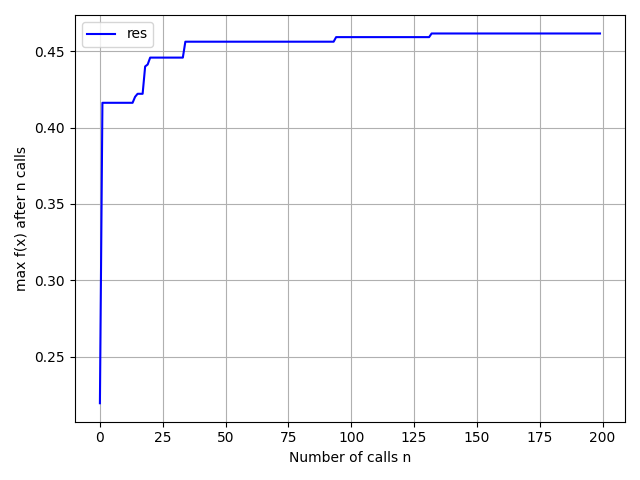

In [73]:
#The image is just dumped into the working directory, but is moved somewhere more fitting

os.replace('./ETM_Optimization_Convergence.png', './octis/results/ETM_Optimization_Convergence.png')

Image(filename='./octis/results/ETM_Optimization_Convergence.png')

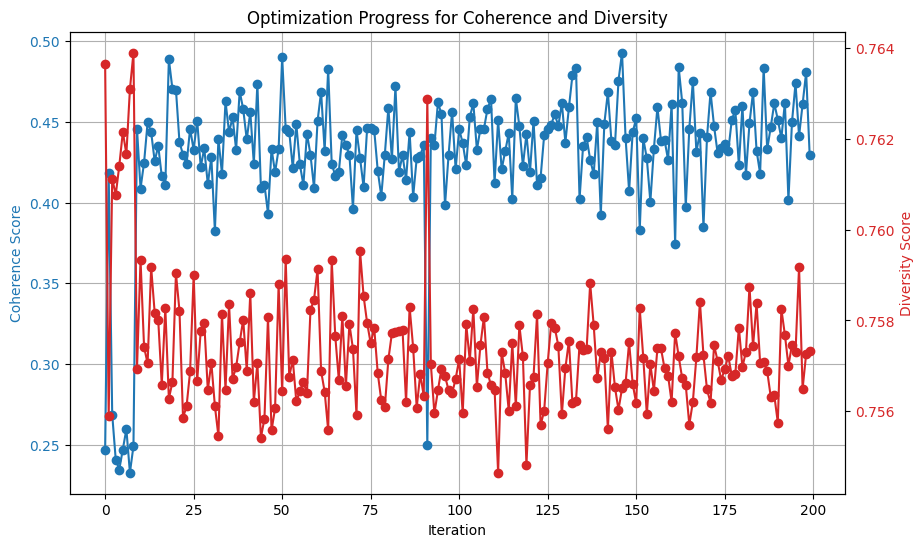

In [36]:
# Plotting WECoherenceCentroid' and 'WordEmbeddingsInvertedRBOCentroid' the two metrics
coherence_scores_ETM = [max(run) for run in optimizer_results_ETM.info['dict_model_runs']['WECoherenceCentroid'].values()]
diversity_scores_ETM = [max(run) for run in optimizer_results_ETM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid'].values()]

# Create a figure with twin y-axis for the second metric
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Coherence Score', color='tab:blue')
ax1.plot(coherence_scores_ETM, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
#ax1.set_ylim(0.23, 0.50)

ax2 = ax1.twinx() 
ax2.set_ylabel('Diversity Score', color='tab:red')  
ax2.plot(diversity_scores_ETM, marker='o', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
#ax2.set_ylim(0.75, 0.78)

plt.title('Optimization Progress for Coherence and Diversity')
ax1.grid(True)

plt.show()

In [61]:
# Extract the best configurations based on coherence scores
coherence_scores_ETM = optimizer_results_ETM.info['dict_model_runs']['WECoherenceCentroid']
diversity_scores_ETM = optimizer_results_ETM.info['dict_model_runs']['0_WordEmbeddingsInvertedRBOCentroid']

# Extracting scores and hyperparameter configurations
combined_scores = []
for i, (coherence_run, diversity_run) in enumerate(zip(coherence_scores_ETM.values(), diversity_scores_ETM.values())):
    max_coherence = max(coherence_run)
    max_diversity = max(diversity_run)
    num_topics = optimizer_results_ETM.info['x_iters']['num_topics'][i]
    num_layers = optimizer_results_ETM.info['x_iters']['num_layers'][i]
    num_neurons = optimizer_results_ETM.info['x_iters']['num_neurons'][i]
    learn_rate = optimizer_results_ETM.info['x_iters']['learn_rate'][i]
    activation = optimizer_results_ETM.info['x_iters']['activation'][i]
    optimizer_param = optimizer_results_ETM.info['x_iters']['optimizer'][i]
    dropout = optimizer_results_ETM.info['x_iters']['dropout'][i]
    
    combined_scores.append((max_coherence, max_diversity, num_topics, num_layers, num_neurons, learn_rate, activation, optimizer_param, dropout))

# Sort by coherence score first and take the top ten
top_ten_by_coherence = sorted(combined_scores, key=lambda x: x[0], reverse=True)[:10]

# Select the configuration with the highest diversity score from the top ten
best_overall_ETM = max(top_ten_by_coherence, key=lambda x: x[1])

# Print the best configuration
print("Best Coherence Score:", best_overall_ETM[0])
print("Corresponding Diversity Score:", best_overall_ETM[1])
print("Best Configuration: num_topics =", best_overall_ETM[2], 
      ", num_layers =", best_overall_ETM[3],
      ", num_neurons =", best_overall_ETM[4],
      ", learn_rate =", best_overall_ETM[5],
      ", activation =", best_overall_ETM[6],
      ", optimizer =", best_overall_ETM[7],
      ", dropout =", best_overall_ETM[8])


Best Coherence Score: 0.4806725309903266
Corresponding Diversity Score: 0.7572589879575945
Best Configuration: num_topics = 99 , num_layers = 1 , num_neurons = 750 , learn_rate = 0.04655802555184136 , activation = sigmoid , optimizer = adam , dropout = 0.03639473996509752


In [ ]:
best_num_topics = best_overall_ETM[2]
best_num_layers = best_overall_ETM[3]
best_num_neurons = best_overall_ETM[4]
best_learn_rate = best_overall_ETM[5]
best_activation = best_overall_ETM[6]
best_optimizer = best_overall_ETM[7]
best_dropout = best_overall_ETM[8]

# Now the ETM model is instantiated with the best hyperparameters
best_model_ETM = ETM(num_topics=best_num_topics,
                     #num_layers=best_num_layers,
                     #num_neurons=best_num_neurons,
                     #solver=best_optimizer,
                     activation=best_activation,
                     dropout=best_dropout, 
                     batch_size=128,
                     use_partitions=False,
                     embeddings_path='./word2vec/word2vec_model.bin',
                     )

# Train the model with the dataset
best_model_ETM = best_model_ETM.train_model(dataset_final)

In [65]:
dump(best_model_ETM, './octis/models/best_model_ETM.joblib', compress=('lzma', 9))
best_model_ETM = load('./octis/models/best_model_ETM.joblib')

In [66]:
top_words_per_topic_ETM = best_model_ETM['topics']

# Display the top words for each topic
for topic_id, words in enumerate(top_words_per_topic_ETM):
    print("Topic", topic_id + 1, ":", words)

Topic 1 : ['willing', 'mistake', 'examined', 'understanding', 'pardon', 'travel', 'vivid', 'stage', 'sum', 'labour']
Topic 2 : ['remote', 'rapid', 'willing', 'sum', 'the', 'enthusiasm', 'forgive', 'obtained', 'labour', 'ice']
Topic 3 : ['sex', 'the', 'obtained', 'disappointment', 'ice', 'mistake', 'vivid', 'sum', 'forgive', 'willing']
Topic 4 : ['stage', 'sum', 'travel', 'the', 'willing', 'obtained', 'mistake', 'pardon', 'sex', 'understanding']
Topic 5 : ['mistake', 'willing', 'the', 'sum', 'endeavour', 'understanding', 'obtained', 'rapid', 'vivid', 'impatient']
Topic 6 : ['willing', 'vivid', 'stage', 'travel', 'size', 'forgive', 'remote', 'mistake', 'the', 'ice']
Topic 7 : ['willing', 'obtained', 'affections', 'mistake', 'date', 'rapid', 'examined', 'momentary', 'the', 'conducted']
Topic 8 : ['forgive', 'mistake', 'afterward', 'size', 'travel', 'willing', 'difference', 'examined', 'authority', 'rapid']
Topic 9 : ['understanding', 'forgive', 'momentary', 'willing', 'stage', 'travel', '

In [67]:
dump(top_words_per_topic_ETM,'./analysis/top_words_per_topic_ETM.joblib')

['./analysis/top_words_per_topic_ETM.joblib']

In [68]:
topic_document_matrix_ETM = best_model_ETM["topic-document-matrix"]
topic_distribution_df_ETM = get_document_topic_percentages(topic_document_matrix_ETM)
topic_distribution_df_ETM.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 90,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99
Document ID,,,,,,,,,,,,,,,,,,,,,
0,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
1,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
2,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
3,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
4,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
5,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
6,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
7,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
8,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01


In [69]:
original_indexes = dataset_final._Dataset__original_indexes
topic_distribution_df_ETM['Original Document Index'] = original_indexes

In [70]:
df_input['input_index'] = df_input.index
df_input['ref'] = df_input['reference'].apply(lambda x: x.rsplit('_', 1)[0])
df_merge = df_input.merge(df_ref, left_on='ref', right_on='reference', how='left')
df_merge['date'] = df_merge['date'].astype('Int64')
df_merge['birthdate'] = df_merge['birthdate'].astype('Int64')
df_merge.head()

,preprocessed_text_x,reference_x,sentiment,input_index,ref,index,reference_y,title,author,date,...,mode,genre,gender,birthdate,nationality,role (central/peripheral/influence),text,source,preprocessed_text_y,tokenized_text
0,fragment adventure turned steed hoping cross d...,Aikin_SirBertran_1,-0.9201,0,Aikin_SirBertran,0,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,...,Fragment,Gothic,NaN,<NA>,English,Central,"SIR BERTRAND, A FRAGMENT:\n\nAFTER this advent...",colors,fragment adventure turned steed hoping cross d...,"['fragment', 'adventure', 'turned', 'steed', '..."
1,plague portion ensuing relating street manner ...,Ainsworth_OldSaintPa_1,0.9773,1,Ainsworth_OldSaintPa,1,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,...,NaN,NaN,m,1805,English,NaN,OLD SAINT PAUL\'S\n\n _A TALE OF THE PLAGUE\n...,pb-manual,plague portion ensuing relating street manner ...,"['plague', 'portion', 'ensuing', 'relating', '..."
2,whatsoever away terms included language charac...,Ainsworth_Rookwood_1,0.9989,2,Ainsworth_Rookwood,2,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,...,Novel,Gothic,m,1805,English,Central,"\nThe Project Gutenberg EBook of Rookwood, by ...",colors,whatsoever away terms included language charac...,"['whatsoever', 'away', 'terms', 'included', 'l..."
3,doll wangos leaving justice skill witches spea...,Ainsworth_TheLancash_1,-0.9998,3,Ainsworth_TheLancash,3,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,...,NaN,NaN,m,1805,English,NaN,Proofreading Team.\n\n\n\n\n\n\n[Illustration:...,pb-manual,doll wangos leaving justice skill witches spea...,"['doll', 'wangos', 'leaving', 'justice', 'skil..."
4,note text little work finished year intended i...,Austen_Northanger_1,1.0000,4,Austen_Northanger,5,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,...,NaN,NaN,f,1775,English,NaN,Northanger Abbey\n\n\nby Jane Austen\n\n(1803)...,gutenberg,note text little work finished year intended i...,"['note', 'text', 'little', 'work', 'finished',..."


In [71]:
# merging of topic distribution with features
# reorganizing the order of columns and cleanup
df_txt_features_ETM = df_merge.merge(topic_distribution_df_ETM, right_on='Original Document Index', left_on='input_index')
df_txt_features_ETM=df_txt_features_ETM.drop(['text', 'preprocessed_text_y','tokenized_text','preprocessed_text_x', 'index', 'ref', 'Original Document Index'], axis=1)
df_txt_features_ETM.rename(columns={'reference_x': 'reference','reference_y': 'text_key'}, inplace=True)
df_txt_features_ETM = df_txt_features_ETM[['input_index'] + [col for col in df_txt_features_ETM.columns if col != 'input_index']]
df_txt_features_ETM.rename(columns={'role (central/peripheral/influence)': 'role'}, inplace=True)
df_txt_features_ETM.head()

,input_index,reference,sentiment,text_key,title,author,date,period,mode,genre,...,Topic 90,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99
0,0,Aikin_SirBertran_1,-0.9201,Aikin_SirBertran,"Sir Bertrand, A Fragment","Aikin, John and Anna Laetitia",1773,Romantic,Fragment,Gothic,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
1,1,Ainsworth_OldSaintPa_1,0.9773,Ainsworth_OldSaintPa,Old Saint Paul's: A Tale of the Plague and the...,"Ainsworth, William Harrison",1841,NaN,NaN,NaN,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
2,2,Ainsworth_Rookwood_1,0.9989,Ainsworth_Rookwood,Rookwood,"Ainsworth, William Harrison",1834,NaN,Novel,Gothic,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
3,3,Ainsworth_TheLancash_1,-0.9998,Ainsworth_TheLancash,The Lancashire Witches: A Romance of Pendle Fo...,"Ainsworth, William Harrison",1848,NaN,NaN,NaN,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01
4,4,Austen_Northanger_1,1.0000,Austen_Northanger,Northanger Abbey,"Austen, Jane",1817,NaN,NaN,NaN,...,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01


In [72]:
df_txt_features_ETM.to_csv('./analysis/df_txt_features_ETM.csv', index=False)
df_txt_features_ETM=pd.read_csv('./analysis/df_txt_features_ETM.csv')

pyLDAvis exports

In [73]:
topic_term_dists_ETM = best_model_ETM["topic-word-matrix"]
doc_topic_dists_ETM = best_model_ETM["topic-document-matrix"]
doc_topic_dists_ETM = doc_topic_dists_ETM.T


In [74]:
dump(topic_term_dists_ETM, './analysis/topic_term_dists_ETM.joblib')
dump(doc_topic_dists_ETM, './analysis/doc_topic_dists_ETM.joblib')

['./analysis/doc_topic_dists_ETM.joblib']